In [4]:
import warnings
import itertools
import pandas as pd
import plotting as mp
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from data_wrangling import Results_data, Data_preparation
from collections import OrderedDict
from results_plotting import Sarima_predictions, line_plot_predictions, baseline_forecasts
from baseline_models import Baseline_previous, Baseline_average
plt.style.use('fivethirtyeight')

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
def plot_results(df):
    cross_val_scores = {}
    cross_val_scores['baseline_previous'] = df.iloc[0]['baseline_previous']
    cross_val_scores['baseline_average'] = df.iloc[0]['baseline_averages']
    cross_val_scores['sarima'] = df.iloc[0]['sarima_x']
    cross_val_scores['sarimaX_fixed'] = df.iloc[2]['sarima_x']
    cross_val_scores['sarimaX_variable'] = df.iloc[6]['sarima_x']
    results = OrderedDict(sorted(cross_val_scores.items(), key=lambda t: t[0]))
    values = [v/1000. for v in results.values()]
    plt.figure(figsize=(8,6))
    plt.bar(range(len(results)),values, color='b', alpha=0.5,align='center')
    plt.xticks(range(len(results)), results.keys(),rotation=45)
    plt.ylabel('Cross validation RMSE [kWh]')
    plt.title(df.iloc[0]['project'])
    plt.show()
    pass
    

In [6]:
project_name = 'project_a1e0'
freq = 'D'
season = 7
path = '../../capstone_data/Azimuth/clean/{}'.format(project_name)

In [7]:
dp = Data_preparation(path,freq)
df = dp.get_data()
y = dp.create_variable(agg='sum',feature='power_all')
path_res = 'output_'+project_name+'_daily'
results = Results_data(path_res).get_data().df
res_sarima = results[results['model']=='sarima']
res_sarimax = results[results['model']=='sarimaX']

In [8]:
params_s = (res_sarima.iloc[0]['order'],res_sarima.iloc[0]['seasonal_order'])
params_sX = (res_sarimax.iloc[0]['order'],res_sarimax.iloc[0]['seasonal_order'])
print params_s
print params_sX

((0, 1, 2), (0, 0, 0, 7))
((0, 0, 2), (1, 0, 0, 7))


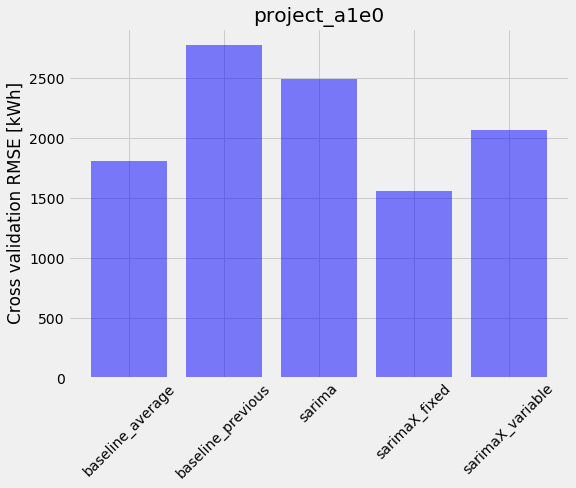

In [9]:
plot_results(results)

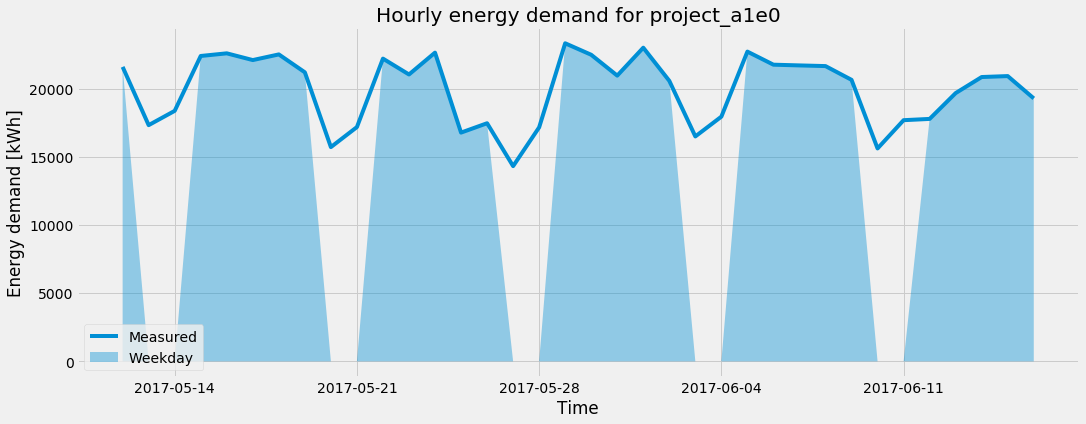

In [10]:
plt.figure(figsize=(16,6))
y_plot = y.iloc[:,0]/1000.
plt.plot(y.index, y_plot,label='Measured')
plt.fill_between(y.index, y.iloc[:,-1]*y_plot, alpha=0.4, label='Weekday')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Energy demand [kWh]')
title = 'Hourly energy demand for {}'.format(project_name)
plt.title(title)
plt.show()

## T-dependance

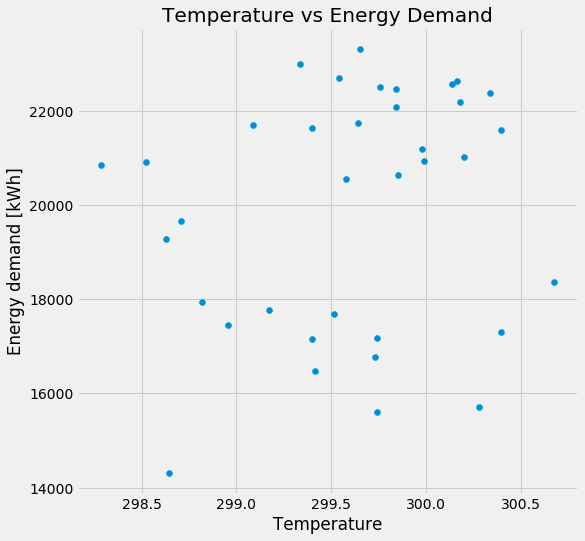

In [11]:
plt.figure(figsize=(8,8))
y_plot = y.iloc[:,0]/1000
plt.scatter(y.iloc[:,1], y_plot)
plt.xlabel('Temperature')
plt.ylabel('Energy demand [kWh]')
title = 'Temperature vs Energy Demand'.format(project_name)
plt.title(title)
plt.show()

In [12]:
y_train = y[:-2*season]
y_test = y[-2*season:]

In [13]:
endog = y_train.ix[:,0]
exog = sm.add_constant(y_train.ix[:,1:])

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


## Training

In [18]:
predictions = []
window =14

In [19]:
prediction_b1, prediction_b2 = baseline_forecasts(y,len(y)-window,'D')


baseline - previous...
Baseline-previous test RMSE 2612107.00787
baseline - averages....
Baseline-averages test RMSE 1765696.84367


In [20]:
predictions.append(['baseline_previous',prediction_b1])
predictions.append(['baseline_average',prediction_b2])

In [21]:
sp = Sarima_predictions(params_s)
results_s = sp.rolling_predictions_sarima(y,window,len(y)-window,types=0)
sp = Sarima_predictions(params_sX)
results_sX = sp.rolling_predictions_sarima(y,window,len(y)-window,types=2)

In [22]:
prediction_s = results_s['sarima'][0]
prediction_sX = results_sX['sarimaX'][0]

In [23]:
prediction_s[5]=prediction_s[4]

In [24]:
predictions.append(['sarima',prediction_s])
predictions.append(['sarimaX_f',prediction_sX])

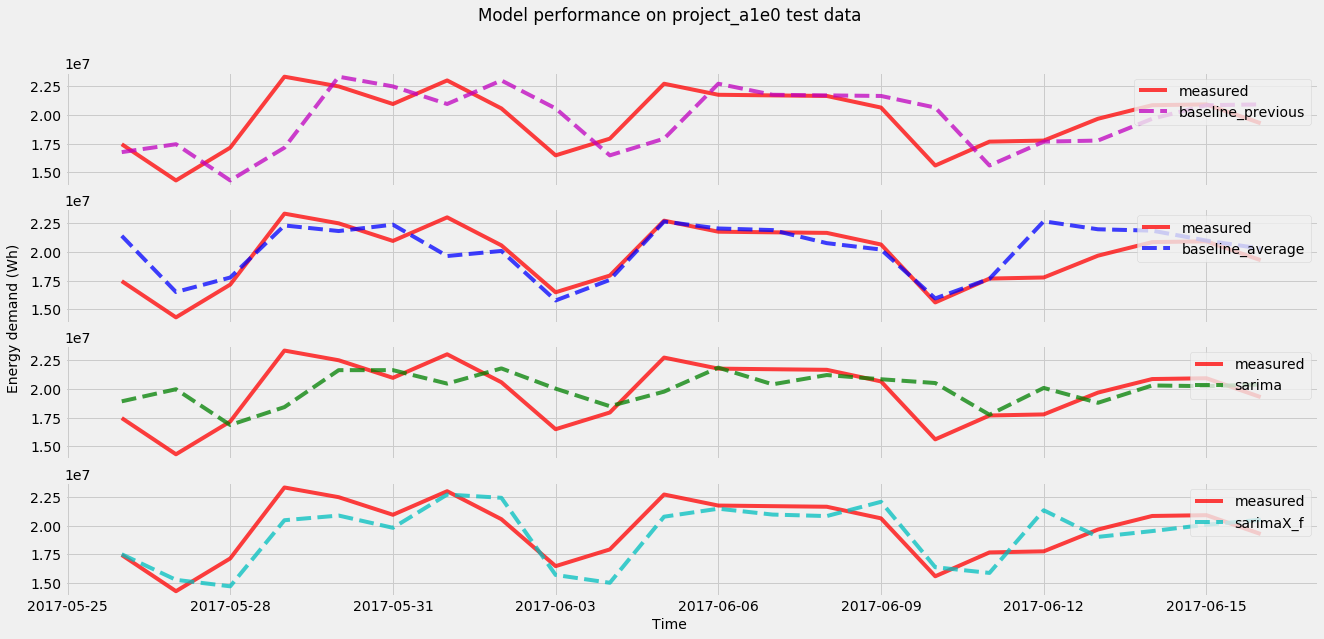

In [25]:
line_plot_predictions(project_name, predictions,y.iloc[window:])

In [26]:
sp = Sarima_predictions(params_sX)
model = sp.fit_sarimaX((y_train.iloc[:,0],y_train.iloc[:,1:]))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         power_all   No. Observations:                   22
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 7)   Log Likelihood                -236.620
Date:                           Fri, 01 Sep 2017   AIC                            485.240
Time:                                   18:39:40   BIC                            491.787
Sample:                               05-12-2017   HQIC                           486.782
                                    - 06-02-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T-1         5.561e+04   7155.426      7.771      0.000    4.16e+04    6.96e+04
weekday     4.741e+06   1.91e+06      2.479      0.013    9.92e+05    8.49e+06
ma.L1          0.4691      0.459      1.021      0.307      -0.431       1.369
ma.L2          0.3038      0.847      0.359      0.720      -1.356       1.964
ar.S.L7       -0.2208      0.485     -0.455      0.649      -1.172       0.730
sigma2      3.338e+12      1.248   2.67e+12      0.000    3.34e+12    3.34e+12
===================================================================================
Ljung-Box (Q):                        9.24   Jarque-Bera (JB):                 4.10
Prob(Q):                              0.82   Prob(JB):                         0.13
Heteroskedasticity (H):               1.77   Skew:                            -1.14
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.87e+28. Standard errors may be unstable.
"""

## Forecasts

In [27]:
forecasts = []

In [28]:
forecast_b1, forecast_b2 = baseline_forecasts(y,2*season,'D')


baseline - previous...
Baseline-previous test RMSE 2399237.3441
baseline - averages....
Baseline-averages test RMSE 1533515.80036


In [29]:
forecasts.append(['baseline_previous',forecast_b1])
forecasts.append(['baseline_average',forecast_b2])

In [30]:
params_s = (res_sarima.iloc[0]['order'],res_sarima.iloc[0]['seasonal_order'])
params_sX = (res_sarimax.iloc[2]['order'],res_sarimax.iloc[2]['seasonal_order'])
print params_s
print params_sX

((0, 1, 2), (0, 0, 0, 7))
((0, 0, 1), (0, 0, 0, 7))


In [31]:
sp = Sarima_predictions(params_s)
results_s = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=0)
sp = Sarima_predictions(params_sX)
results_sX = sp.rolling_predictions_sarima(y,len(y)-2*season,2*season,types=2)

In [32]:
forecast_s = results_s['sarima'][0]
forecast_sX = results_sX['sarimaX'][0]

In [33]:
forecasts.append(['sarima',forecast_s])
forecasts.append(['sarimaX_f',forecast_sX])

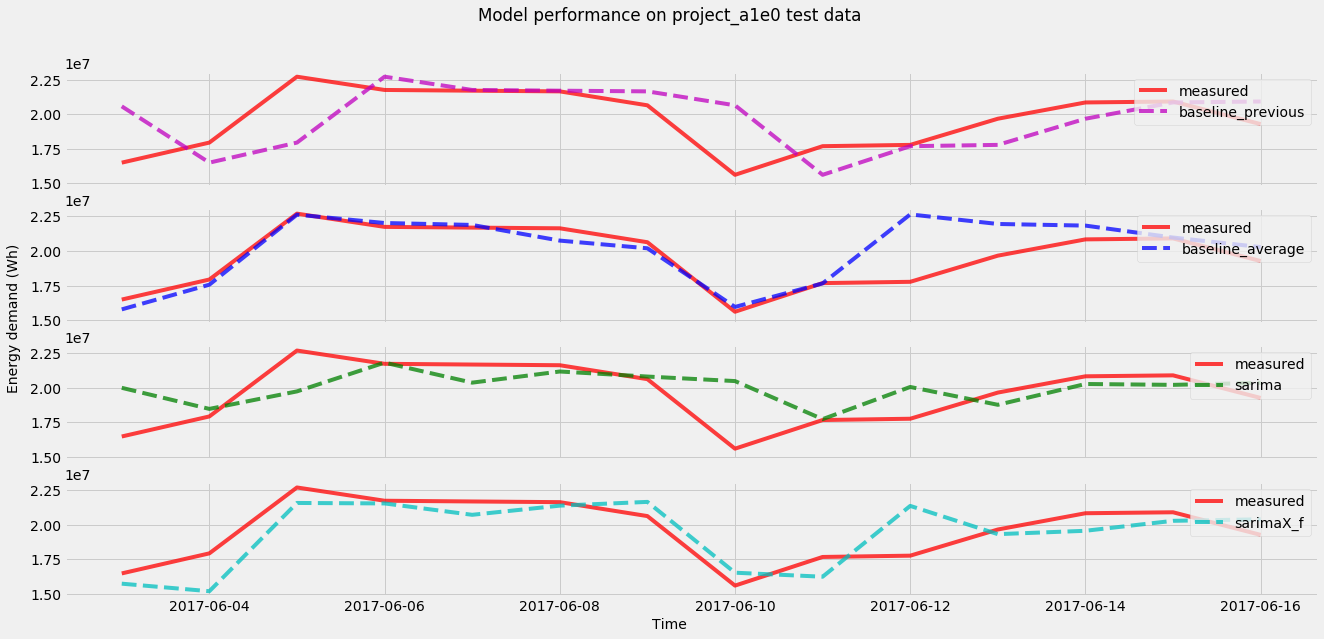

In [34]:
line_plot_predictions(project_name, forecasts,y_test)